In [1]:
# This notebook was created by Aurora Cecilia Araujo Martínez in August 21, 2020
# Lawrence Berkeley National Laboratory / University of Guanajuato
# For ngspice download go to: http://ngspice.sourceforge.net
# Note: This script is compatible with Python 3 and macOS

# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import subprocess # Library to run ngspice on shell
import os 
import time
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
axis_font = {'size':'18','fontname':'Times New Roman'}
del matplotlib.font_manager.weight_dict['roman'] 
matplotlib.font_manager._rebuild()
from matplotlib.lines import Line2D

# Recommandation: Run first all the cells where a function is define.
# *** A function is define as -> def function(inputs):...

# Electric circuit model for a pancake coil

This script was made to model a REBCO pancake coil of n-turns in DC conditions. Each turn can be divided into m sections of REBCO tape, that are represented by a voltage source that follows the power law: 
    
$V_{HTS}= L E_c(\frac{I}{I_c})^n= V_c(\frac{I}{I_c})^n$

where, L is the section length, E_c is the electric field criterion of 100 μV/m at which the critical current ($I_c$) is defined, I the current, and n is the index value. 

The model also includes the inter-tape contact resistance between each turn. 

The next figures show an example of the model for 3 turns divided into 8 sections. 



<img src="3-turncoil.png">
<img src="3-turnmodel.png">

In [13]:
# We use this section to generate the SPICE netlist for DC analysis

# ------Input-------
# nt = number of turns
# m = number of divisions per turn
# L = Length of each section given nt and m, based on the inner radiameter
# Ic, n = the critical current and n value per section 
# Rs = Cu stabilizer resistance
# Rc = contact resistance
# Imax is the maximum transport current 

def generatingnetlist_pancake(filename,nt,m,L,Ic,n,Rs,Rc,Imax):
    # Saving the labels of the elements to read current and voltage from NGSPICE
    Labels = ['Index','i-sweep']
    
    # Stabilizer resistances
    for i in range(nt*m):
        Labels.append(f'@rs{i+1}[i]')
    # HTS voltage sources
    for i in range(nt*m):
        Labels.append(f'@b{i+1}[i]')
    # Contact resistances
    for i in range((nt-1)*m+1):
        Labels.append(f'@rc{i+1}[i]')
    # Voltage on each node
    for i in range(nt*m):
        Labels.append(f'v({i+1})')
    
    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    
    #print(probe)
    
    # Constant Parameters for the model
    
    Ec = 100E-6 # [V/m] Electric field criterion
    Vc = Ec*L 
    
    
    step = 1 # Step of current
    Data_points = int(Imax/step + 1) # Data points calculated directly 
    
    # Start writing netlist
    with open(filename, 'w') as output:
        output.write(f'* Netlist REBCO n-turn pancake coil\n')
        output.write(f'I1 0 1 120\n') # Current source DC
        
        # HTS Voltage sources of all coil turns
        for i in range(nt*m):
            if i == nt*m-1: # Last section is connected to ground
                output.write(f'B{i+1} {i+1} 0 V={Vc[i]}*pow((I(B{i+1})/{Ic[i]}),{n[i]})\n')
            else:
                output.write(f'B{i+1} {i+1} {i+2} V={Vc[i]}*pow((I(B{i+1})/{Ic[i]}),{n[i]})\n')
                
        # Cu stabilizer
        for i in range(nt*m):
            if i == nt*m-1: # Last section is connected to ground
                output.write(f'Rs{i+1} {i+1} 0 {Rs[i]}\n')
            else:
                output.write(f'Rs{i+1} {i+1} {i+2} {Rs[i]}\n')
        
        # Contact resistance / transverse coating
        for i in range((nt-1)*m+1):
            output.write(f'Rc{i+1} {i+1} {m+i+1} {Rc[i]}\n')
    
            
        output.write(f'.dc I1 0 {Imax} {step}\n')
        output.write('.print dc '+probe+'\n')
        output.write('.end\n')
    return Labels,Data_points

In [3]:
# This function is used to run the netlist in ngspice using subprocess and load the data
# A .txt file is saved with the output da
# filename -> of the ngspice netlist 
# Data_points = output from generatenetlist_pancake
# nt, m = number of turns, divisions per turn

        
def readdata(filename,Data_points,nt,m):
    Labels = ['Index','i-sweep']
    
    # Stabilizer resistances
    for i in range(nt*m):
        Labels.append(f'@rs{i+1}[i]')
    # HTS voltage sources
    for i in range(nt*m):
        Labels.append(f'@b{i+1}[i]')
    # Contact resistances
    for i in range((nt-1)*m+1):
        Labels.append(f'@rc{i+1}[i]')
    # Voltage on each node
    for i in range(nt*m):
        Labels.append(f'v({i+1})')
        
    # Run ngspice file on shell
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)
    data = np.zeros ([Data_points, len(Labels)])
    
    flag = False
    for line in src:
        #print(line)
        # Here we initialize the ngspice data array
        ''' This part is not used because we fixed the data points when we generate the netlist
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)
        '''
        
        
        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            flag = True
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len(temp_list)
            #print('n_columns\n',n_columns)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if flag == True: # Only if the first index has passed for the ac analysis
            if line[0].isdigit():
                temp_data = [float(x) for x in line.split()]

                for c in range(n_columns):
                    r = fill[c]

                    data [r][index[c]] = temp_data [c]
                    fill [c] = fill [c] + 1
                    if fill [c] == Data_points:
                        fill [c] = 0
    return data # data saved from spice

In [4]:
# The input values to generate the ngspice netlist are stabilished here
# d_i = inner diameter must be in [m]
# nt = number of turns
# m = number of divitions per turn
# Ic_a, n_a = averaged critical current and n-value for REBCO tape

def input_ngspice(d_i,nt,m,Ic_a,n_a): # Resistances that we input in the NGspice model
    # Geometry values of tape and coating
    w = 4E-3 # [m] Width of the tape
    ts = 40E-6 # [m] Thickness of the Cu stabilizer in REBCO tape (Total)
    t_tape = 100E-6 # [m] Total thickness of the REBCO tape 
    tf = 0.5E-6 # [m] Thickness of the VOx film
    
    # Coil geometry 
    diameter_array = []
    for i in range(nt):
        diameter_array.append(d_i+(i*2*t_tape))
    diameter_array = np.asarray(diameter_array)
    radii = diameter_array/2
    # the length per section in each turn
    l = []
    for i in range(nt):
        for j in range(m):
            l.append(np.pi*diameter_array[i]/m)
    l = np.asarray(l)
    # Resistivity values
    pf_LN = 0.12 # [Ohm m] VOx resistivity at 77 K (VALUE FOR TAPE 26)
    pf_RT = 0.01 # [Ohm m] VO resitivity at room temperature ~ 294 K

    pcu_RT = 1.68E-8 # [Ohm m] Cu resistivity 1.68E-8 at 300 K
    pcu_LN = 0.2E-8 # [Ohm m] Cu resistivity 77 K
    pcontact = 1E-8 #[Ohm m^-2]
    #pcontact = 0.01e-8 #new low value july 14, 2020
    #pcontact = 0.01e-4 #new high value july 16, 2020
    
    # Temperature array for all sections in the whole coil
    T = np.zeros(nt*m)+77 # setting the temperature at 77 K
    # Cu resistivity
    rho_cu = resistivity_cu(T)
    
    '''
    # VOx resistances
    rho_vox = resistivity_vox2(T,pf_LN,pf_RT)
    Rl = Rl_vox(rho_vox,l,w,tf) # Longitudinal resistances
    Rt_b = Rt_vox(rho_vox,l,w,tf) # Tranverse resistances
    Rt = resistances_transverse(Rt_b,nu) # Tranverse resistances fixed
    '''
    # Cu stabilizer resistance 
    Rs = Rcu_stabilizer(rho_cu,l,ts,w) # Stabilizer resistances
    #Rst_b = Rcu_stabilizer(rho_cu1,ts,l,w) # Stabilizer resistances transvers // not used now
    #Rst = resistances_transverse(Rst_b,nu)
    
    # Contact resistance
    Rc = []
    for i in range((nt-1)*m):
        Rc.append(R_contact(pcontact,l[i],w))
    Rc.append(Rc[-1])
    Rc = np.asarray(Rc)
    
    # Critical current and n values
    Ic = np.zeros(nt*m)+1E-3  # 0.001 is a minimum value that we used to treat the voltage sources as non superconductive
    n = np.zeros(nt*m)+n_a
    for i in range(nt*m):
        if T[i] <= 90:
            Ic[i]= Ic_gradient(Ic_a,T[i])
    return Ic,n,Rs,Rc,l,radii

In [5]:
# Functions defined to calculate the resistances of Cu stabilizer, contact and coating
def resistivity_cu(T):
    rho_cu = (0.2E-8)+((1.48E-8)/223)*(T-77)
    return rho_cu

# Resistance of Cu stabilizer
def Rcu_stabilizer(rho,l,ts,w):
    Rs = rho*l/(ts*w)
    return Rs

# Contact resistance
def R_contact(rho,l,w_cu):
    Rc = rho/(l*w_cu)
    return Rc

# Critical current between 77 K and 90 K
def Ic_gradient(Ic_77,T):
    return Ic_77/13*(-T+90)

# Ecuacions for resistivity of coating
#rho = resistivity, l = length, w = width, tf = film thickness
def Rl_vox(rho,l,w,tf): # Longitudinal resistance of coating
    Rl = rho*l/(tf*w)
    return Rl
    
def Rt_vox(rho,l,w,tf): # Transverse resistance of coating
    Rt = rho*tf/(l*w)
    return Rt

# Total length of the tape used for the coil
def tape_length(l):
    tape_length = []
    l_temp = 0
    for i in range(len(l)):
        l_temp = l_temp+l[i]
        tape_length.append(l_temp)
    tape_length = np.asarray(tape_length)
    return tape_length

In [6]:
# Arranging data to plot current and voltage distribution

def current_profile(data,nt,m): # This definition returns the calculated current and voltages 
    
    # Stabilizer current
    Is_profile = [] 
    for i in range(nt*m):
        Is = data[:,2+i]
        Is_profile.append(Is[-1])    
    Is_profile = np.array(Is_profile) 
    
    # HTS voltage sources current
    Ihts_profile = []
    for i in range(nt*m):
        Ihts = data[:,2+(nt*m)+i]
        Ihts_profile.append(Ihts[-1])
    Ihts_profile = np.array(Ihts_profile) 
    
    # Contact resistances current
    Irc_profile = []
    for i in range((nt-1)*m+1):
        Irc = data[:,2+2*(nt*m)+i]
        Irc_profile.append(Irc[-1])
    Irc_profile = np.array(Irc_profile)
    
    # Voltage in each node
    v = []
    for i in range(nt*m):
        v_end = data[:,2+2*(nt*m)+i+(nt-1)*m+1]
        v.append(v_end[-1])
    v = np.array(v) 
    return Is_profile,Ihts_profile, Irc_profile,v
    #print('Is profile', Is_profile)
    

In [7]:
# Calculating magnetic field at the center of the coil
# Input: current (Ihts), radius of each turn (r), number of turns (nt), number of sections per turn (m)

def Bfield(Ihts,r,nt,m):
    B_turn = []
    for i in range(nt):
        B = 4*np.pi*(1E-7)*np.sum(Ihts[i*m:i*m+m])/(2*r[i]*m)
        B_turn.append(B) 
    B_turn = np.asarray(B_turn)
    B_total = np.sum(B_turn)
    return B_total

In [8]:
# Magnetic field vs. transport current

def BvsIop(d_i,nt,m,Ic_a,n_a,Imax,filename):
    Ic,n,Rs,Rc,l,radii = input_ngspice(d_i,nt,m,Ic_a,n_a) # Input for netlist
    Labels,Data_points = generatingnetlist_pancake(filename,nt,m,l,Ic,n,Rs,Rc,Imax) # Generate spice netlist
    data = readdata(filename,Data_points,nt,m) # Run spice netlist and save data
    Is,Ihts,Irc,v = current_profile(data,nt,m) # Arrange current and voltage 
    tape_l = tape_length(l) 
    B_azi = Bfield(Ihts+Is,radii,nt,m) # Total Magnetic field at center of coil 
    B_hts = Bfield(Ihts,radii,nt,m) # Magnetic field at center of coil with only current of hts voltage source
    return B_azi,B_hts,v[0],Is,Ihts,Irc,v,tape_l

In [9]:
# Function to get the voltage in each section
def voltage_section(v,nt,m):
    v_section = []
    for i in range(nt*m):
        if i < nt*m-1:
            v_section.append(v[i]-v[i+1])
        else:
            v_section.append(v[i])
    v_section = np.asarray(v_section)
    return v_section

# Simple example to use the script

- 1. Define the initial parametersof the coil
- 2. Calculate ngspice model values (Ic,n, and resistances) for the coil
- 3. Generate spice netlist
- 4. Run spice and save data
- 5. Arrange data to plot results for the specified transport current Iop = Imax 

The coil for this example doesn't have defects. We simulate the results for a particular value of the transport current.

In [16]:
# 1. Define the initial parametersof the coil
d_i = 60E-3 # Inner diameter [m]
nt = 3 # Number of turns
m = 8 # Number of divisions 
Ic_a = 85 # Average Critical current
n_a = 33 # Average n-value
Imax = 100 # Transport current
filename = 'pancake_model.cir'

# 2. Calculate ngspice model values (Ic,n, and resistances) for the coil
Ic,n,Rs,Rc,l,radii = input_ngspice(d_i,nt,m,Ic_a,n_a)
 
# 3. Generate spice netlist
Labels,Data_points = generatingnetlist_pancake(filename,nt,m,l,Ic,n,Rs,Rc,Imax)

# 4. Run spice and save data
data = readdata(filename,Data_points,nt,m)

# 5. Arrange data to plot results when Iop= Imax (specified transport current)
Is,Ihts,Irc,v = current_profile(data,nt,m)
tape_l = tape_length(l)

<IPython.core.display.Javascript object>


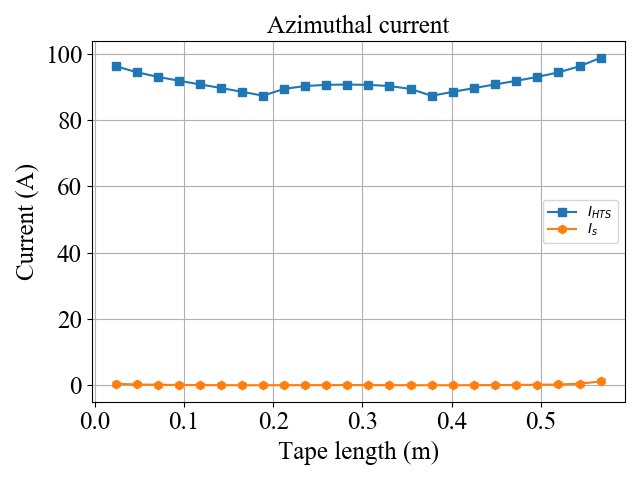

In [17]:
# Plotting Azimuthal currents

%matplotlib notebook 

fig,ax = plt.subplots()

plt.xticks(**axis_font)
plt.yticks(**axis_font)


ax.plot(tape_l,Ihts,'-s',label = '$I_{HTS}$')

ax.plot(tape_l,Is,'-h',label = '$I_{s}$')

#ax.set_ylim(-10,90)
ax.set_xlabel('Tape length (m)',**axis_font)
ax.set_ylabel('Current (A)',**axis_font)
ax.legend(labelspacing=0.001,ncol=1,loc='center right',prop={'family':'Times New Roman', 'size':10}) 


plt.yticks(**axis_font)
plt.title('Azimuthal current',**axis_font)
plt.tight_layout()
ax.grid()
plt.savefig(f'Azimuthal_current{nt}_turns_{m}divisions.png',dpi = 400)
plt.show()

<IPython.core.display.Javascript object>


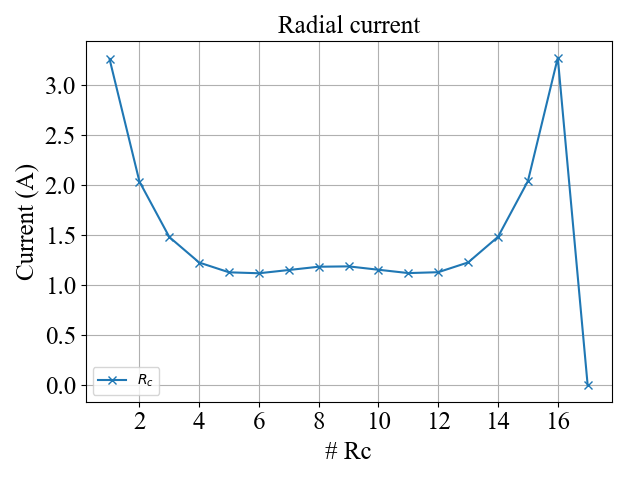

In [18]:
# Plotting radial current

fig,ax = plt.subplots()
#ax.set_xticks(section)
#ax.set_xticklabels(labels,**axis_font)

plt.xticks(**axis_font)
plt.yticks(**axis_font)

nodes = np.arange((nt-1)*m+1)+1
ax.plot(nodes,Irc,'-x',label='$R_c$')
#ax.set_ylim(-5,2)
#ax.set_xlim(18, 20)
ax.set_xlabel('# Rc',**axis_font)
ax.set_ylabel('Current (A)',**axis_font)
#plt.title('Current distribution without coating, $I_{transport}$ = 80 A',**axis_font)
ax.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 

plt.yticks(**axis_font)
plt.title('Radial current',**axis_font)
plt.tight_layout()
ax.grid()
plt.savefig(f'Radial_current{nt}_turns_{m}divisions.png',dpi=400)
plt.show()

<IPython.core.display.Javascript object>


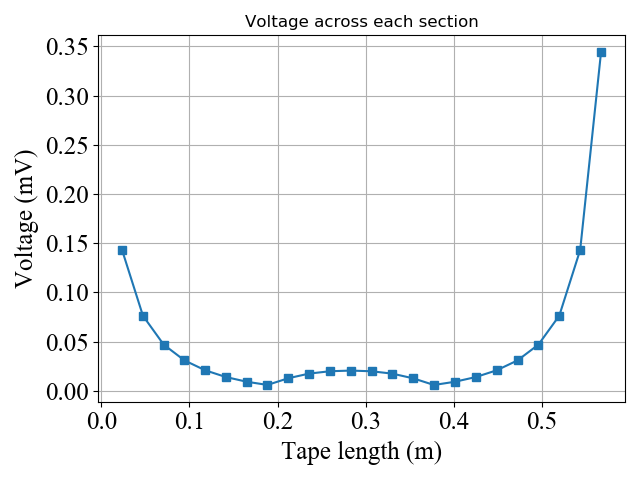

In [19]:
# Plotting voltages at each section

fig,ax = plt.subplots()
#ax.set_xticks(section)
#ax.set_xticklabels(labels,**axis_font)

plt.xticks(**axis_font)
plt.yticks(**axis_font)

v_section = voltage_section(v,nt,m)
ax.plot(tape_l,v_section/1e-3,'-s')


#ax.set_ylim(-5,2)
#ax.set_xlim(18, 20)
ax.set_title('Voltage across each section')
ax.set_xlabel('Tape length (m)',**axis_font)
ax.set_ylabel('Voltage (mV)',**axis_font)

plt.yticks(**axis_font)
plt.tight_layout()
ax.grid()
plt.savefig(f'voltage_nodes{nt}_turns_{m}divisions.png',dpi=400)
plt.show()

# Plotting magnetic field vs. transport current

- This part calculates the magnetic field at the center of coil for an overcurrent case.


<IPython.core.display.Javascript object>


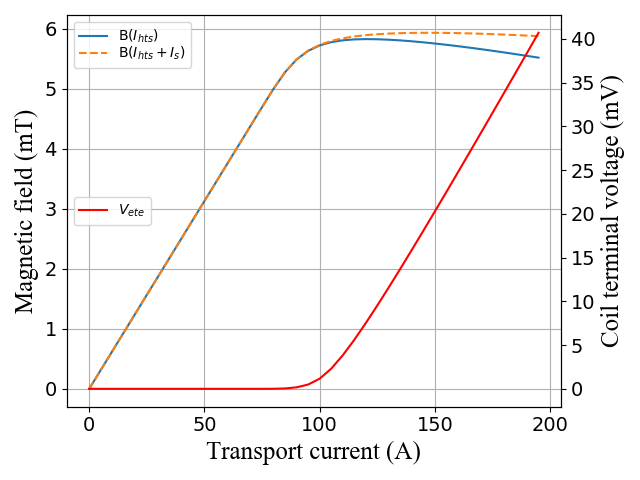

In [21]:
# Initial values 

d_i = 60E-3 
nt = 3
m = 8
Ic_a = 85
n_a = 33
filename = f'pancake_model{nt}_turn_{m}div.cir'

B_total = []
B_vhts = []
V_end = []
Iop = np.arange(0,200,5) # Range of transport current

for i in range(len(Iop)):
    B_azi,B_hts,v1,Is,Ihts,Irc,v, tape_l = BvsIop(d_i,nt,m,Ic_a,n_a,Iop[i],filename)
    B_total.append(B_azi)
    B_vhts.append(B_hts)
    V_end.append(v1)
    
B_total = np.asarray(B_total)
B_vhts = np.asarray(B_vhts)
V_end = np.asarray(V_end)
    
fig,ax = plt.subplots()

ax.plot(Iop,B_vhts/1E-3,label = 'B($I_{hts}$)')
ax.plot(Iop,B_total/1E-3,'--',label = 'B($I_{hts}+I_s$)')


ax.set_xlabel('Transport current (A)',**axis_font)
ax.set_ylabel('Magnetic field (mT)',**axis_font)
#ax.set_ylim(-0.5,9)

ax2 = ax.twinx()
ax2.plot(Iop,V_end/1e-3,color='red',label = '$V_{ete}$')
ax2.set_ylabel('Coil terminal voltage (mV)',**axis_font)
#ax2.set_ylim(-0.05,0.5)

ax.legend(labelspacing=0.001,ncol=1,loc='upper left',prop={'size':10}) 
ax2.legend(labelspacing=0.001,ncol=1,loc='center left',prop={'size':10}) 
ax.grid()
#plt.xticks(**axis_font)
#plt.yticks(**axis_font)

plt.tight_layout()
plt.savefig(f'BcvsIop{nt}turns_{m}div.png')
plt.show()



# Simulating a coil with a defect 

- With the definition "defect" we simulate the case when a section of has a lower value of the critical current. 
- The magnetic field at the center of the coil is calculated, the current distribution in the azimuthal and radial direction is plotted. 


In [22]:
# Simulation for a coil with defect

# Input: d_i = inner diameter, nt = number of turns, m = divisions per turn, 
# Ic_a = average critical current, n_a = averaged n-value, Imax = transport current, filename for netlist and output
# Ic_defect = critical current at the defect
# d_position = number of turn where the defect is 1 = turn 1, 2 = turn 2..., 
# The defect is fixed to the section m (last section of the turn) but this can be changed in Ic[d_position*m-1] = Ic_defect

def defect(d_i,nt,m,Ic_a,n_a,Imax,filename,Ic_defect,d_position):
    Ic,n,Rs,Rc,l,radii = input_ngspice(d_i,nt,m,Ic_a,n_a)
    Ic[d_position*m-1] = Ic_defect
    Labels,Data_points = generatingnetlist_pancake(filename,nt,m,l,Ic,n,Rs,Rc,Imax)
    data = readdata(filename,Data_points,nt,m)
    Is,Ihts,Irc,v = current_profile(data,nt,m)
    tape_l = tape_length(l)
    B_azi = Bfield(Ihts+Is,radii,nt,m)
    B_hts = Bfield(Ihts,radii,nt,m)
    return B_azi,B_hts,v[0],Is,Ihts,Irc,v, tape_l # v[0] is the end to end voltage

<IPython.core.display.Javascript object>


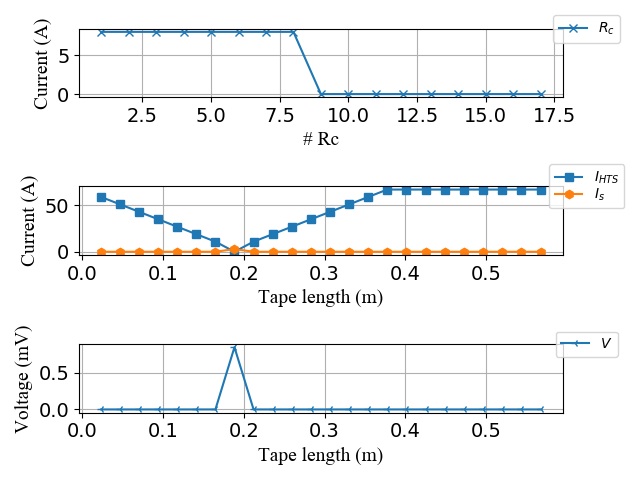

In [23]:
# Simulation for a coil with defect

axis_font2 = {'size':'14','fontname':'Times New Roman'}

# Initial values for the coil 

d_i = 60E-3
nt = 3
m = 8
Ic_a = 100 # [A]
Ic_defect = 1E-3 # [A]
n_a = 33
Imax = 67
d_position = 1 # turn 1
filename = f'pancake_model{nt}_turn_{m}div.cir'

# Calculating field, current and voltages
B_azi,B_hts,v1,Is,Ihts,Irc,v, tape_l = defect(d_i,nt,m,Ic_a,n_a,Imax,filename,Ic_defect,d_position)

# Voltage in each section
V_section = voltage_section(v,nt,m)

# Plotting results

fig, (ax, axb, axc) = plt.subplots(3)
    
plt.setp(ax.get_xticklabels(), visible=True)
#plt.xticks(**axis_font)
#plt.yticks(**axis_font)

axb.plot(tape_l,Ihts,'-s',label = '$I_{HTS}$')
axb.plot(tape_l,Is,'-h',label = '$I_{s}$')
#ax.set_ylim(-10,90)
axb.set_xlabel('Tape length (m)',**axis_font2)
axb.set_ylabel('Current (A)',**axis_font2)
axb.legend(labelspacing=0.001,ncol=1,loc='center right',prop={'family':'Times New Roman', 'size':10}) 
axb.legend(bbox_to_anchor=(1.05, 1),labelspacing=0.001,ncol=1,loc='center',prop={'family':'Times New Roman', 'size':10}) 
#ax.set_ylim(-100,200)
axb.grid() 

nodes = np.arange((nt-1)*m+1)+1
ax.plot(nodes,Irc,'-x',label='$R_c$')
ax.set_xlabel('# Rc',**axis_font2)
ax.set_ylabel('Current (A)',**axis_font2)
ax.legend(bbox_to_anchor=(1.05, 1),labelspacing=0.001,ncol=1,loc='center',prop={'family':'Times New Roman', 'size':10}) 
ax.grid()

axc.plot(tape_l,V_section/1E-3,'-3',label='$V$')
axc.set_xlabel('Tape length (m)',**axis_font2)
axc.set_ylabel('Voltage (mV)',**axis_font2)
axc.legend(bbox_to_anchor=(1.05, 1),labelspacing=0.001,ncol=1,loc='center',prop={'family':'Times New Roman', 'size':10}) 
axc.grid()




plt.tight_layout()
plt.savefig(f'Currents{nt}turns_{m}div_defect_turn{d_position}_def{Ic_defect}A_imax{Imax}.png',dpi = 400)
plt.show()

# Simulation of coil with defect setting Ic to 0 after we pass the average critical current

- In this case we try to simulate the approximate the field profile to a real case where a drop of the field is observed after passing the critical current

- For instance: A 3-turn coil is analyzed. The Ic on turn 1 is brought to zero after the transport current surpases the original averaged critical current. For turns 2 and 3, the Ic remains as the average value.



In [62]:
# Magnetic field vs. transport current

def BvsIop_zero(d_i,nt,m,Ic_a,n_a,Imax,filename):
    Ic,n,Rs,Rc,l,radii = input_ngspice(d_i,nt,m,Ic_a,n_a) # Input for netlist
    Ic[:int(m)] = 0.001 # Setting Ic average of the turn 1 to zero
    Labels,Data_points = generatingnetlist_pancake(filename,nt,m,l,Ic,n,Rs,Rc,Imax) # Generate spice netlist
    data = readdata(filename,Data_points,nt,m) # Run spice netlist and save data
    Is,Ihts,Irc,v = current_profile(data,nt,m) # Arrange current and voltage 
    tape_l = tape_length(l) 
    B_azi = Bfield(Ihts+Is,radii,nt,m) # Total Magnetic field at center of coil 
    B_hts = Bfield(Ihts,radii,nt,m) # Magnetic field at center of coil with only current of hts voltage source
    return B_azi,B_hts,v[0],Is,Ihts,Irc,v,tape_l

<IPython.core.display.Javascript object>


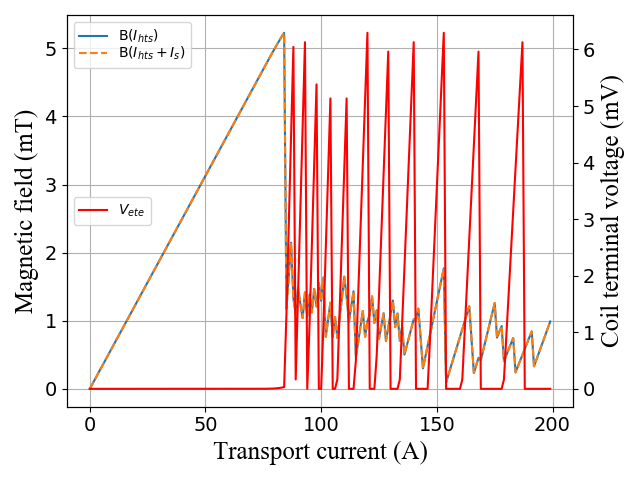

In [40]:
# Initial values 

d_i = 60E-3 
nt = 3
m = 8
Ic_a = 85
n_a = 33
filename = f'pancake_model{nt}_turn_{m}div.cir'

B_total = []
B_vhts = []
V_end = []
Iop = np.arange(0,200,1) # Range of transport current

for i in range(len(Iop)):
    if Iop[i] < Ic_a:
        B_azi,B_hts,v1,Is,Ihts,Irc,v, tape_l = BvsIop(d_i,nt,m,Ic_a,n_a,Iop[i],filename)
    else: # set I_c
        B_azi,B_hts,v1,Is,Ihts,Irc,v, tape_l = BvsIop_zero(d_i,nt,m,Ic_a,n_a,Iop[i],filename)
    B_total.append(B_azi)
    B_vhts.append(B_hts)
    V_end.append(v1)
    
B_total = np.asarray(B_total)
B_vhts = np.asarray(B_vhts)
V_end = np.asarray(V_end)
    
fig,ax = plt.subplots()

ax.plot(Iop,B_vhts/1E-3,label = 'B($I_{hts}$)')
ax.plot(Iop,B_total/1E-3,'--',label = 'B($I_{hts}+I_s$)')


ax.set_xlabel('Transport current (A)',**axis_font)
ax.set_ylabel('Magnetic field (mT)',**axis_font)
#ax.set_ylim(-0.5,9)

ax2 = ax.twinx()
ax2.plot(Iop,V_end/1e-3,color='red',label = '$V_{ete}$')
ax2.set_ylabel('Coil terminal voltage (mV)',**axis_font)
#ax2.set_ylim(-0.05,0.5)

ax.legend(labelspacing=0.001,ncol=1,loc='upper left',prop={'size':10}) 
ax2.legend(labelspacing=0.001,ncol=1,loc='center left',prop={'size':10}) 
ax.grid()
#plt.xticks(**axis_font)
#plt.yticks(**axis_font)

plt.tight_layout()
plt.savefig(f'BcvsIop{nt}turns_{m}div_modified.png')
plt.show()




<IPython.core.display.Javascript object>


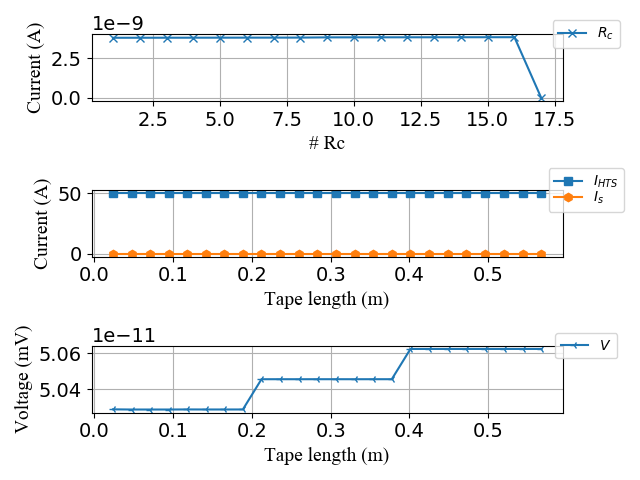

In [54]:
# Current distribution at 50 A (below Ic_a = 85 A)
Itransport = 50 #[A]
# Calculating field, current and voltages
B_azi,B_hts,v1,Is,Ihts,Irc,v,tape_l = BvsIop(d_i,nt,m,Ic_a,n_a,Itransport,filename)
#B_azi,B_hts,v1,Is,Ihts,Irc,v,tape_l = defect(d_i,nt,m,Ic_a,n_a,Imax,filename,Ic_defect,d_position)

# Voltage in each section
V_section = voltage_section(v,nt,m)

# Plotting results

fig, (ax, axb, axc) = plt.subplots(3)
    
plt.setp(ax.get_xticklabels(), visible=True)
#plt.xticks(**axis_font)
#plt.yticks(**axis_font)

axb.plot(tape_l,Ihts,'-s',label = '$I_{HTS}$')
axb.plot(tape_l,Is,'-h',label = '$I_{s}$')
#ax.set_ylim(-10,90)
axb.set_xlabel('Tape length (m)',**axis_font2)
axb.set_ylabel('Current (A)',**axis_font2)
axb.legend(labelspacing=0.001,ncol=1,loc='center right',prop={'family':'Times New Roman', 'size':10}) 
axb.legend(bbox_to_anchor=(1.05, 1),labelspacing=0.001,ncol=1,loc='center',prop={'family':'Times New Roman', 'size':10}) 
#ax.set_ylim(-100,200)
axb.grid() 

nodes = np.arange((nt-1)*m+1)+1
ax.plot(nodes,Irc,'-x',label='$R_c$')
ax.set_xlabel('# Rc',**axis_font2)
ax.set_ylabel('Current (A)',**axis_font2)
ax.legend(bbox_to_anchor=(1.05, 1),labelspacing=0.001,ncol=1,loc='center',prop={'family':'Times New Roman', 'size':10}) 
ax.grid()

axc.plot(tape_l,V_section/1E-3,'-3',label='$V$')
axc.set_xlabel('Tape length (m)',**axis_font2)
axc.set_ylabel('Voltage (mV)',**axis_font2)
axc.legend(bbox_to_anchor=(1.05, 1),labelspacing=0.001,ncol=1,loc='center',prop={'family':'Times New Roman', 'size':10}) 
axc.grid()




plt.tight_layout()
plt.savefig(f'Currents{nt}turns_{m}div_imax{Itransport}.png',dpi = 400)
plt.show()

<IPython.core.display.Javascript object>


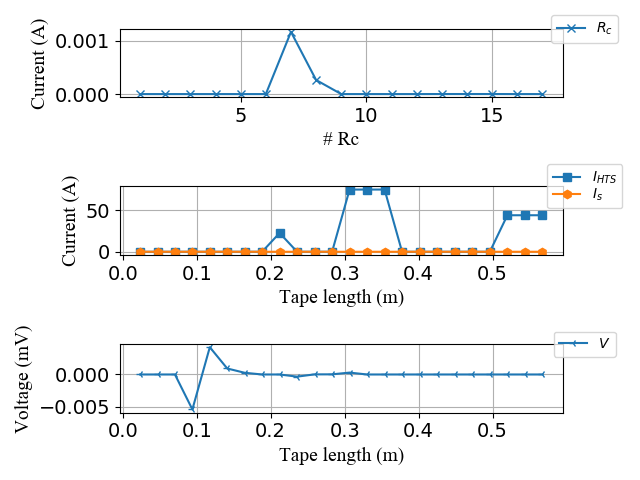

In [61]:
# Current distribution at 90 A (below Ic_a = 85 A)
Itransport = 100 #[A]
# Calculating field, current and voltages for transport current > Ic_A
B_azi,B_hts,v1,Is,Ihts,Irc,v, tape_l = BvsIop_zero(d_i,nt,m,Ic_a,n_a,Iop[i],filename)

# Voltage in each section
V_section = voltage_section(v,nt,m)

# Plotting results

fig, (ax, axb, axc) = plt.subplots(3)
    
plt.setp(ax.get_xticklabels(), visible=True)
#plt.xticks(**axis_font)
#plt.yticks(**axis_font)

axb.plot(tape_l,Ihts,'-s',label = '$I_{HTS}$')
axb.plot(tape_l,Is,'-h',label = '$I_{s}$')
#ax.set_ylim(-10,90)
axb.set_xlabel('Tape length (m)',**axis_font2)
axb.set_ylabel('Current (A)',**axis_font2)
axb.legend(labelspacing=0.001,ncol=1,loc='center right',prop={'family':'Times New Roman', 'size':10}) 
axb.legend(bbox_to_anchor=(1.05, 1),labelspacing=0.001,ncol=1,loc='center',prop={'family':'Times New Roman', 'size':10}) 
#ax.set_ylim(-100,200)
axb.grid() 

nodes = np.arange((nt-1)*m+1)+1
ax.plot(nodes,Irc,'-x',label='$R_c$')
ax.set_xlabel('# Rc',**axis_font2)
ax.set_ylabel('Current (A)',**axis_font2)
ax.legend(bbox_to_anchor=(1.05, 1),labelspacing=0.001,ncol=1,loc='center',prop={'family':'Times New Roman', 'size':10}) 
ax.grid()

axc.plot(tape_l,V_section/1E-3,'-3',label='$V$')
axc.set_xlabel('Tape length (m)',**axis_font2)
axc.set_ylabel('Voltage (mV)',**axis_font2)
axc.legend(bbox_to_anchor=(1.05, 1),labelspacing=0.001,ncol=1,loc='center',prop={'family':'Times New Roman', 'size':10}) 
axc.grid()




plt.tight_layout()
plt.savefig(f'Currents{nt}turns_{m}div_imax{Itransport}.png',dpi = 400)
plt.show()